In [1]:
import math
import os, sys
import subprocess
import re
from argparse import ArgumentParser, ArgumentTypeError
from datetime import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise ArgumentTypeError('Boolean value expected.')

parser = ArgumentParser()
parser.add_argument('-o', '--output', dest='output', default='', help='Location of output(s)')
parser.add_argument('-d', '--debug', type=str2bool, dest='debug', default=True, help='Debug logging specific files and extra verbosity')
parser.add_argument('-c', '--use_cuda', type=str2bool, dest='use_cuda', default=True, help='Use cuda if cuda supported')
parser.add_argument('-a', '--artifacts', dest='artifacts', default='', help='Directory to save artifacts such as checkpoints')
parser.add_argument('-e', '--epochs', type=int, dest='train_epochs', default=10, help='Number of epochs to train on')
parser.add_argument('-p', '--print_every', type=int, dest='print_every', default=100, help='After how many iterations to print a status')
parser.add_argument('-v', '--validate_every', type=int, dest='validate_every', default=10, help='After how many epochs to validate loss on test set')
parser.add_argument('-s', '--save_every', type=int, dest='save_every', default=0, help='After how many epochs before saving a checkpoint (0 to turn off)')
parser.add_argument('-b', '--batch_size', type=int, dest='batch_size', default=1, help='Batch size to train on')

parser.add_argument('--input_length', type=int, dest='input_length', default=0, help='Maximum input sequence length')
parser.add_argument('--output_length', type=int, dest='output_length', default=0, help='Maximum output sequence length')
parser.add_argument('--conversation_depth', type=int, dest="conversation_depth", default=4, help='Depth of conversations, the minimum should be 2.')

args, unknown = parser.parse_known_args()

use_cuda = args.use_cuda and torch.has_cuda

device = 'cuda' if use_cuda else 'cpu'

model_dir = args.output
artifacts_dir = args.artifacts

input_length = args.input_length
output_length = args.output_length

train_epochs = max(args.train_epochs, 1)
print_every = max(args.print_every, 1)
validate_every = max(args.validate_every, 0)
save_every = max(args.save_every, 0)
batch_size = max(args.batch_size, 1)

debug_mode = args.debug

conversation_depth = max(args.conversation_depth, 2)

# Prepare the Data

Create vocabulary and load the data

In [2]:
from vocab import Vocab
voc = Vocab(input_length, conversation_depth=conversation_depth)

In [3]:
# FOLDERS = [
#     'ditfxx_subs', 'steins_gate_subs', 'guilty_crown_subs',
#     'ngnl_subs', 'rezero_subs', 'promised_neverland_subs', 'your_lie_subs',
#     'shield_hero_subs', 'fate_ubw_subs'
#     ]

multiplier = [60, 60 * 60, 24 * 60 * 60]
def get_time(timestr: str) -> int:
    time = timestr.split(':')
    final_time = 0
    ms = float(time[-1]) * 1000
    final_time += int(ms)
    for i in range(len(time)-2):
        t = time[-2-i]
        final_time += multiplier[i] * int(t)
    return final_time

normalize_pattern = re.compile(r'(\{[\\\*][\w\(\)\\\,\*]*|\})', re.M)
sub_space = re.compile(r'(\{|\\[nN])', re.M)
insert_space = re.compile(r'([\w\"])([\.\!\,\?\W])')
def normalize_text(text: str) -> str:
    text = normalize_pattern.sub('', text)
    text = sub_space.sub(' ', text)
    text = re.sub(r'([\'\"])', r' \1 ', text)
    text = re.sub(r'([\.\!\?\W])(\w)', r'\1 \2', text)
    text = ' '.join(text.split())
    return insert_space.sub(r'\1 \2', text)

number_match = re.compile(r'\d+')
def match_num(text: str) -> int:
    x = number_match.findall(text)
    return int(''.join(x) if len(x) > 0 else 0)

for folder in os.listdir('data'):
    if not os.path.isdir(os.path.join('data', folder)):
        continue
    dir = os.listdir(os.path.join('data', folder))
    dir.sort(key=match_num)
    print(f'Parsing folder: {folder}')
    for f in dir:
        filepath = os.path.join(os.getcwd(), 'data', folder, f)
        if not os.path.isfile(filepath): continue
        if debug_mode:
            print(f'  Opening file: {f}')
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as sub_file:
            is_event = False
            line = True
            while not is_event and line:
                line = sub_file.readline()
                if not line: break
                if line.rstrip() == "[Events]":
                    is_event = True
            current_format = False
            current_conversation = []
            
            voc.switch_context(f)
            line = True
            # for line in sub_file.readlines():
            while line:
                try:
                    line = sub_file.readline()
                except UnicodeDecodeError:
                    print('    Error decoding a line, skipped.')
                if line.startswith('Format:'):
                    line = line[len('Format:'):].strip().split(',')
                    for i in range(len(line)):
                        line[i] = line[i].strip()
                    current_format = line
                    continue
                if current_format == False or not line.startswith('Dialogue:'): continue
                line = line[len('Dialogue:'):].strip().split(',')
                line[len(current_format)-1] = ','.join(line[len(current_format)-1:])
                dialogue = dict(zip(current_format, line))
                if not dialogue['Style'].lower() in ['main', 'default', 'italics', 'flashback', 'ngnl-main']: continue
                # Extract variables
                speaker = ''
                for k in ['Actor', 'Name']:
                    if k in dialogue:
                        speaker = dialogue[k]
                        break
                text = normalize_text(dialogue['Text'])
                time = get_time(dialogue['Start'])
                style = dialogue['Style']

                if len(text.strip()) == 0: continue

                voc.add_conversation({
                    'speaker': speaker,
                    'line': text,
                    'when': time,
                    'style': style
                })
                voc.add_sentence(text)

convos = 0
for k, c in voc.conversations.items():
    convos += len(c)

if input_length == 0:
    input_length = 2**math.ceil(math.log2(voc.longest_tokenized * (conversation_depth - 1)))
if output_length == 0:
    output_length = 2**math.ceil(math.log2(voc.longest_tokenized))

print(f'Done! Num conversations: {convos}, num words: {len(voc.words)}, longest convo: {voc.longest_tokenized}\n\n')

Parsing folder: aldnoah_zero_subs
  Opening file: [HorribleSubs] Aldnoah Zero - 01 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 02 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 03 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 04 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 05 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 06 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 07 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 08 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 09 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 10 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 11 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 12 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 13 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 14 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 15 [720p].ass
  Opening file: [HorribleSubs] Aldnoah Zero - 16 [720p].ass
  Open

# Create the Model

Using preset hyperparameters from Amadeus

In [4]:
from amadeus_model import Amadeus

model = Amadeus(num_tokens=voc.tokenizer.get_vocab_size(), \
    enc_seq_len=input_length, dec_seq_len=output_length)

print(f'input size: {input_length} output size: {output_length}')

unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
1024 512


# Train the model

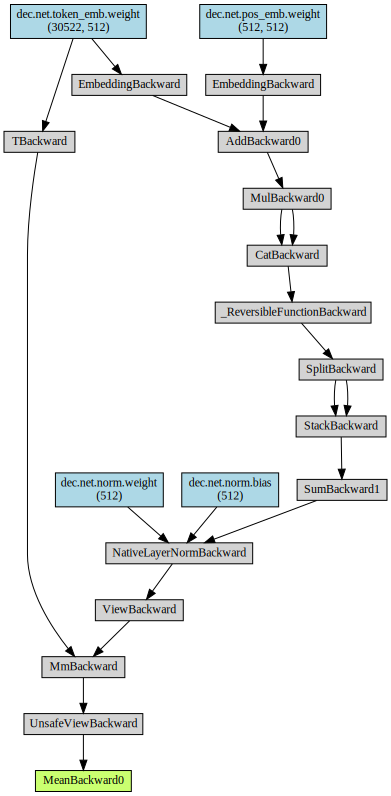

In [5]:
in_seq = torch.randint(0, voc.tokenizer.get_vocab_size(), (1, model.in_seq_len))
out_seq = torch.randint(0, voc.tokenizer.get_vocab_size(), (1, model.out_seq_len))
mask = torch.ones(1, model.in_seq_len).bool()

y = model(in_seq, out_seq, mask=mask)

try:
    from torchviz import make_dot
    display(make_dot(y.mean(), params=dict(model.named_parameters())))
except Exception:
    print('Torch graph was not created, continuing.')

in_seq = None
out_seq = None
mask = None

In [6]:
if use_cuda:
    model = model.cuda()

## Split train/test data

In [7]:
from sklearn.model_selection import train_test_split

from vocab import ConversationIter

train_set, test_set = train_test_split(voc.get_conversations(), test_size=0.2)

train_set = ConversationIter(train_set, in_seq_len=model.in_seq_len, \
    out_seq_len=model.out_seq_len, batch_size=batch_size)
test_set = ConversationIter(test_set, in_seq_len=model.in_seq_len, \
    out_seq_len=model.out_seq_len, batch_size=batch_size)

## Train the model

In [8]:
from adafactor import Adafactor

has_gradient = False
try:
    from gradient_statsd import Client
    has_gradient = True
    client = Client()
except ImportError:
    print('gradient_statsd package is not installed, not using gradient metrics.')

optimizer = Adafactor(model.parameters())

start_time = datetime.now()

def format_time(dt: datetime) -> str:
    return format(dt, '%Y-%m-%d-%H.%M.%S')

def train(conv_iter: ConversationIter):
    model.train()
    total_loss = 0
    counter = 0
    accrued_loss = 0
    start = datetime.now()
    for i, (inputs, targets) in enumerate(conv_iter):
        mask = torch.tensor([inp.attention_mask for inp in inputs]).bool()

        inputs = torch.tensor([inp.ids for inp in inputs])
        targets = torch.tensor([tar.ids for tar in targets])

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
            mask = mask.cuda()

        optimizer.zero_grad()
        loss = model(inputs, targets, mask=mask, return_loss=True)
        loss.mean().backward()
        optimizer.step()
        
        accrued_loss += loss.item()
        total_loss += loss.item()
        counter += 1
        
        if (i + 1) % print_every == 0:
            print(f'  Iter {i+1} (Took {(datetime.now() - start).total_seconds():.3f}s): AverageLoss: {accrued_loss/print_every:.4f}')
            total_loss += accrued_loss
            accrued_loss = 0
            start = datetime.now()
    return total_loss / max(counter, 1)

def validate(conv_iter: ConversationIter):
    model.eval(False)
    with torch.no_grad():
        inp, tar = conv_iter.random_sample(pad_in=True)
        mask = torch.tensor([i.attention_mask for i in inp]).bool()
        inputs = torch.tensor([i.ids for i in inp])
        targets = torch.tensor([t.ids for t in tar])

        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
            mask = mask.cuda()
        
        loss = model(inputs, targets, mask=mask, return_loss=True)
        print(f'Validation loss: {loss.item()}')
    return loss.item()

def save_checkpoint(epoch: int):
    tmp_model_dir = artifacts_dir
    if os.getenv('GCLOUD_ENABLE') and model_dir.startswith('gs://'):
            tmp_model_dir = '/tmp'
    checkpoint_path = os.path.join(tmp_model_dir, 'checkpoints')
    checkpoint_file = os.path.join(model_path, model_name)

    checkpoint_name = f'amadeus-performer-{format_time(start_time)}-{epoch}.pt'
    Path(checkpoint_path).mkdir(parents=True, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_file)

    if os.getenv('GCLOUD_ENABLE') and artifacts_dir.startswith('gs://'):
        subprocess.check_call([
            'gsutil', 'cp', checkpoint_file,
            os.path.join(artifacts_dir, checkpoint_name)
        ])
    print(f'Saved checkpoint: {checkpoint_name}')

gradient_statsd package is not installed, not using gradient metrics.


In [9]:
print(f'\n\nStarting train on device: {device}')
print(f'Training on {train_epochs} epochs with batch size of {batch_size}')
print(f'Validating every {validate_every} and saving every {save_every}\n')

for epoch in range(train_epochs):
    prompt = f'Training epoch #{epoch+1} of {train_epochs}:'
    print(f'{prompt}\n{"=" * len(prompt)}')

    total = datetime.now()

    total_loss = train(train_set)

    if has_gradient:
        client.increment('EPOCHS', 1)
        client.gauge('LOSS_PER_EPOCH', total_loss)

    print(f'Epoch {epoch+1} took {(datetime.now()-total).total_seconds():.3f}s')

    if validate_every > 0 and (epoch + 1) % validate_every == 0:
        validate_loss = validate(test_set)
        if has_gradient:
            client.gauge('VALIDATE_LOSS', validate_loss)

    if save_every > 0 and (epoch + 1) % save_every == 0:
        save_checkpoint(epoch + 1)

    print('\n\n')

tmp_model_dir = model_dir
if os.getenv('GCLOUD_ENABLE') and model_dir.startswith('gs://'):
        tmp_model_dir = '/tmp'
model_path = os.path.join(tmp_model_dir, 'models')
model_name = f'amadeus-performer-{format_time(start_time)}.pt'
model_file = os.path.join(model_path, model_name)
Path(model_path).mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_file)

if os.getenv('GCLOUD_ENABLE') and model_dir.startswith('gs://'):
    subprocess.check_call([
        'gsutil', 'cp', model_file,
        os.path.join(model_dir, model_name)
    ])
        
print('Finished training and saved model in models directory.')

Starting train on device: cuda
Training on 10 epochs with batch size of 1
Validating every 10 and saving every 0

Training epoch #1 of 10:
  Iter 100 (Took 41.938s): AverageLoss: 6.6036
  Iter 200 (Took 39.397s): AverageLoss: 5.2143
Epoch 1 took 97.461s



Training epoch #2 of 10:
  Iter 100 (Took 39.073s): AverageLoss: 5.8062
  Iter 200 (Took 38.968s): AverageLoss: 5.5060
Epoch 2 took 113.707s



Training epoch #3 of 10:
  Iter 100 (Took 37.644s): AverageLoss: 5.1180
  Iter 200 (Took 37.348s): AverageLoss: 5.2133
Epoch 3 took 103.029s



Training epoch #4 of 10:
  Iter 100 (Took 36.577s): AverageLoss: 5.4950
  Iter 200 (Took 34.654s): AverageLoss: 4.7368
Epoch 4 took 72.592s



Training epoch #5 of 10:
  Iter 100 (Took 35.162s): AverageLoss: 5.2096
  Iter 200 (Took 35.301s): AverageLoss: 5.0634
Epoch 5 took 96.184s



Training epoch #6 of 10:
  Iter 100 (Took 37.986s): AverageLoss: 5.1109
Epoch 6 took 46.132s



Training epoch #7 of 10:
  Iter 100 (Took 34.101s): AverageLoss: 5.3970
 